In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
import numpy as np
import matplotlib.pyplot as plt

# Local imports
from lattice_utils import MultiFileBinDataset, xy_hamiltonian, corr_2d, reweight, plot_tensor_grid
from models import Corr2PtUNet, Corr2PtConv1Layer
from engines import train

In [ ]:
kernel_size = 21
lat_size = 128

multi_file_ds = MultiFileBinDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileBinDataset(folder="L_128/U-Net/val")

single_file_ds = MultiFileBinDataset(folder="L_128/OneLayer/train", min_sep=lat_size // 4 - 1)
single_file_val = MultiFileBinDataset(folder="L_128/OneLayer/val", min_sep=lat_size // 4 - 1)

In [3]:
len(multi_file_ds)

378000

In [4]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [5]:
conv1layer = Corr2PtConv1Layer(lat_size=64, hamiltonian=xy_hamiltonian, kernel_size=kernel_size)
conv1layer.to(device)

Corr2PtConv1Layer(
  (conv): Conv2d(1, 1, kernel_size=(21, 21), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

In [6]:
optim = Adam(conv1layer.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optim, 30, 1e-5)
loader = DataLoader(single_file_ds, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(single_file_val, batch_size=64, shuffle=False, pin_memory=True)

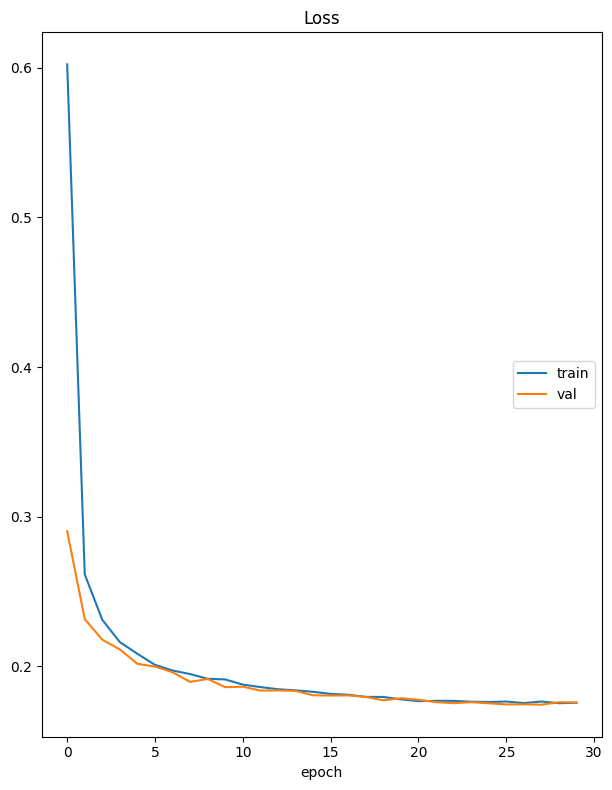

Loss
	train            	 (min:    0.175, max:    0.602, cur:    0.176)
	val              	 (min:    0.174, max:    0.290, cur:    0.176)


In [7]:
train(
    model=conv1layer,
    loader=loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=30,
    device=device,
    val_loader=val_loader,
)

In [6]:
single_file_lats = torch.stack([single_file_ds[i][0] for i in range(len(single_file_ds))])
single_file_temps = torch.stack([single_file_ds[i][1] for i in range(len(single_file_ds))])
sep = (lat_size // 2 - 1) * torch.ones_like(single_file_temps)

init = (
    corr_2d(single_file_lats, torch.tensor(lat_size // 2 - 1), torch.tensor(lat_size // 2 - 1)).detach().cpu().numpy()
)
xi, yi = init.real, init.imag

In [ ]:
conv1layer.eval().to("cpu")

with torch.no_grad():
    final = conv1layer(single_file_lats, single_file_temps, sep, sep).detach().cpu().numpy()
    xf, yf = final.real, final.imag

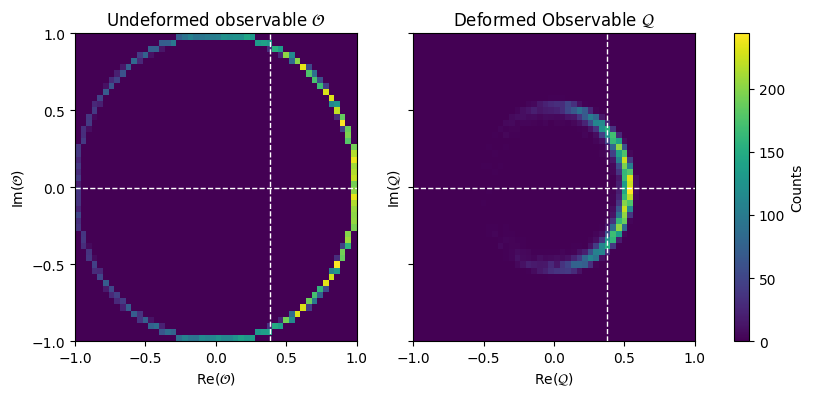

In [9]:
x_means = (xi.mean(), xf.mean())
y_means = (yi.mean(), yf.mean())

xlim = (-1, 1)
ylim = (-1, 1)
# --- Create Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot histograms and store images
h1 = axes[0].hist2d(xi, yi, bins=50, range=[xlim, ylim])
h2 = axes[1].hist2d(xf, yf, bins=50, range=[xlim, ylim])

# Titles and labels
axes[0].set_title("Undeformed observable $\\mathcal{O}$")
axes[1].set_title("Deformed Observable $\\mathcal{Q}$")

axes[0].set_xlabel("$\\mathrm{Re}(\\mathcal{O})$")
axes[0].set_ylabel("$\\mathrm{Im}(\\mathcal{O})$")

axes[1].set_xlabel("$\\mathrm{Re}(\\mathcal{Q})$")
axes[1].set_ylabel("$\\mathrm{Im}(\\mathcal{Q})$")

for i in range(len(axes)):
    axes[i].set_xticks(np.linspace(-1, 1, 5))
    axes[i].set_yticks(np.linspace(-1, 1, 5))
    axes[i].vlines(x_means[i], ymin=-1, ymax=1, color="white", ls="--", lw=1)
    axes[i].hlines(y_means[i], xmin=-1, xmax=1, color="white", ls="--", lw=1)


# --- Shared Colorbar ---
# Use the mappable from one of the histograms (e.g. h1[3])
cbar = fig.colorbar(h1[3], ax=axes.ravel().tolist(), orientation="vertical")
cbar.set_label("Counts")

plt.show()

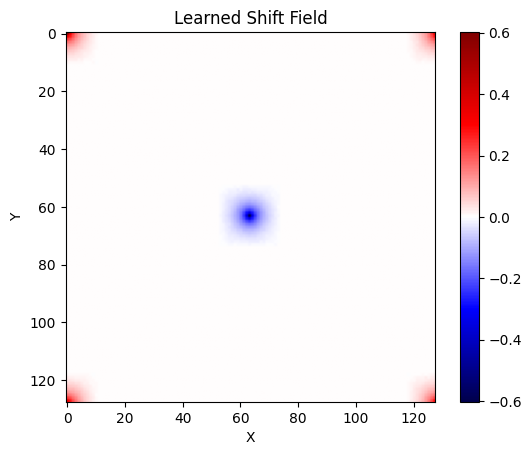

In [10]:
plt.imshow(conv1layer.shifts.cpu().detach().numpy()[0], cmap="seismic")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Learned Shift Field")
plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{x,y}\int_{T_0}^{T_1}dT\,\rho(T)\cdot\mathrm{Re}\left(\left\langle \mathcal{Q}(T,x,y)^2 \right\rangle\right)$$

With $\rho(T)$ some probability density that has support over $[T_0,T_1]$. Currently using a uniform distribtion, but could try reweighting to uniform sampling in $\beta$ rather than $T$, which amounts to the change of variables $d\beta=-dT/T^2$

In [7]:
unet = Corr2PtUNet(128, xy_hamiltonian, min_size=8)
unet.to(device)

from torchinfo import summary

summary(
    unet,
    input_data=(
        torch.zeros((21, 64, 64), device=device, dtype=torch.float32),
        torch.linspace(0.8, 1, 21, device=device, dtype=torch.float32),
        32 * torch.ones(21, device=device, dtype=torch.float32),
        32 * torch.ones(21, device=device, dtype=torch.float32),
    ),
)

Layer (type:depth-idx)                   Output Shape              Param #
Corr2PtUNet                              [21]                      --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv2d: 2-1                       [21, 2, 64, 64]           20
├─ModuleList: 1-30                       --                        (recursive)
│    └─Conv2d: 2-2                       [21, 2, 64, 64]           38
├─MaxPool2d: 1-3                         [21, 2, 32, 32]           --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv2d: 2-3                       [21, 4, 32, 32]           76
├─ModuleList: 1-30                       --                        (recursive)
│    └─Conv2d: 2-4                       [21, 4, 32, 32]           148
├─MaxPool2d: 1-6                         [21, 4, 16, 16]           --
├─ModuleList: 1-13                       --                        (recursive)
│    └─Conv2d: 2-5                     

In [ ]:
from torch.utils.data import WeightedRandomSampler

optim = Adam(unet.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optim, T_max=10, eta_min=1e-5)

weights = reweight(
    torch.stack([multi_file_ds[i][1] for i in range(len(multi_file_ds))]).detach().numpy(), dist=lambda x: x**-2
)
sampler = WeightedRandomSampler(weights, num_samples=len(multi_file_ds), replacement=True)

loader = DataLoader(multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
val_loader = DataLoader(val_multi_file_ds, batch_size=64, shuffle=False, pin_memory=True)

In [20]:
weights

array([32.8125, 32.8125, 32.8125, ..., 21.    , 21.    , 21.    ],
      shape=(378000,), dtype=float32)

In [ ]:
train(
    model=unet,
    loader=loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=10,
    device=device,
    val_loader=val_loader,
)

In [ ]:
# torch.save(unet.state_dict(), "unet_state_dict_128.pth")

In [ ]:
# unet.load_state_dict(torch.load("unet_state_dict_128.pth"))

<All keys matched successfully>

In [ ]:
unet.eval().to("cpu")
results = []

with torch.no_grad():
    for i in range(single_file_lats.size(0)):
        if i % 250 == 0 and i > 0:
            print(f"{i}/{single_file_lats.size(0)}")
        results.append(unet(single_file_lats[i:i+1], single_file_temps[i:i+1], sep[i:i+1], sep[i:i+1]).detach().cpu())

final = torch.cat(results)        
xf, yf = final.real, final.imag

Reached 0/18000
Reached 250/18000
Reached 500/18000
Reached 750/18000
Reached 1000/18000
Reached 1250/18000
Reached 1500/18000
Reached 1750/18000
Reached 2000/18000
Reached 2250/18000
Reached 2500/18000
Reached 2750/18000
Reached 3000/18000
Reached 3250/18000
Reached 3500/18000
Reached 3750/18000
Reached 4000/18000
Reached 4250/18000
Reached 4500/18000
Reached 4750/18000
Reached 5000/18000
Reached 5250/18000
Reached 5500/18000
Reached 5750/18000
Reached 6000/18000
Reached 6250/18000
Reached 6500/18000
Reached 6750/18000
Reached 7000/18000
Reached 7250/18000
Reached 7500/18000
Reached 7750/18000
Reached 8000/18000
Reached 8250/18000
Reached 8500/18000
Reached 8750/18000
Reached 9000/18000
Reached 9250/18000
Reached 9500/18000
Reached 9750/18000
Reached 10000/18000
Reached 10250/18000
Reached 10500/18000
Reached 10750/18000
Reached 11000/18000
Reached 11250/18000
Reached 11500/18000
Reached 11750/18000
Reached 12000/18000
Reached 12250/18000
Reached 12500/18000
Reached 12750/18000
Reache

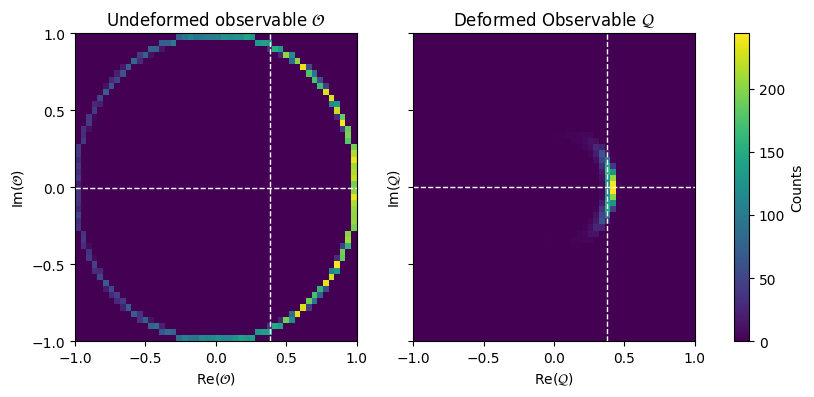

In [25]:
x_means = (xi.mean(), xf.mean())
y_means = (yi.mean(), yf.mean())

xlim = (-1, 1)
ylim = (-1, 1)
# --- Create Plot ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot histograms and store images
h1 = axes[0].hist2d(xi, yi, bins=50, range=[xlim, ylim])
h2 = axes[1].hist2d(xf, yf, bins=50, range=[xlim, ylim])

# Titles and labels
axes[0].set_title("Undeformed observable $\\mathcal{O}$")
axes[1].set_title("Deformed Observable $\\mathcal{Q}$")

axes[0].set_xlabel("$\\mathrm{Re}(\\mathcal{O})$")
axes[0].set_ylabel("$\\mathrm{Im}(\\mathcal{O})$")

axes[1].set_xlabel("$\\mathrm{Re}(\\mathcal{Q})$")
axes[1].set_ylabel("$\\mathrm{Im}(\\mathcal{Q})$")

for i in range(len(axes)):
    axes[i].set_xticks(np.linspace(-1, 1, 5))
    axes[i].set_yticks(np.linspace(-1, 1, 5))
    axes[i].vlines(x_means[i], ymin=-1, ymax=1, color="white", ls="--", lw=1)
    axes[i].hlines(y_means[i], xmin=-1, xmax=1, color="white", ls="--", lw=1)


# --- Shared Colorbar ---
# Use the mappable from one of the histograms (e.g. h1[3])
cbar = fig.colorbar(h1[3], ax=axes.ravel().tolist(), orientation="vertical")
cbar.set_label("Counts")

plt.show()

In [ ]:
from lattice_utils import plot_tensor_grid

input_data = (
    torch.zeros((21, 64, 64), dtype=torch.float32),
    torch.linspace(0.8, 1, 21, dtype=torch.float32),
    32 * torch.ones(21, dtype=torch.float32),
    32 * torch.ones(21, dtype=torch.float32),
)